# Lake modeling - Jonathan, Tagir, and William

## 1. Preprocessing

In [64]:
# %matplotlib widget
import cv2 as cv
import numpy as np
import skimage
import matplotlib.pyplot as plt
import skimage.io as io
from skimage.color import rgb2gray
from skimage.measure import find_contours
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import RBFInterpolator
import pandas as pd
import math
from scipy import signal
from scipy import spatial
from stl import mesh

In [65]:
"""
#3D plotting TEST

#Change the Size of Graph using Figsize
fig = plt.figure(figsize=(10,10))

#Generating a 3D sine wave
ax = plt.axes(projection='3d')
 
 
# assigning coordinates

#points_matrix = np.array([x1=[1,2,3,4,5],y1=[1,2,3,4,5],z1=[[1,1,1,1,1],[2,2,2,2,2],[3,3,3,3,3],[4,4,4,4,4],[5,5,5,5,5]]])
#x = points_matrix[]
x = np.array([1,2,3,4,5])
y = np.array([1,2,3,4,5])
X, Y = np.meshgrid(x, y)
Z = np.array([[1,1,1,1,1],[2,2,2,2,2],[3,3,3,3,3],[4,4,4,4,4],[5,5,5,5,5]])
 
# creating the visualization
ax.plot_wireframe(X, Y, Z, color ='green')
 
# turn off/on axis
plt.axis('off')
plt.show()
# view_init(elev=5, azim=5)
plt.draw()
"""

"\n#3D plotting TEST\n\n#Change the Size of Graph using Figsize\nfig = plt.figure(figsize=(10,10))\n\n#Generating a 3D sine wave\nax = plt.axes(projection='3d')\n \n \n# assigning coordinates\n\n#points_matrix = np.array([x1=[1,2,3,4,5],y1=[1,2,3,4,5],z1=[[1,1,1,1,1],[2,2,2,2,2],[3,3,3,3,3],[4,4,4,4,4],[5,5,5,5,5]]])\n#x = points_matrix[]\nx = np.array([1,2,3,4,5])\ny = np.array([1,2,3,4,5])\nX, Y = np.meshgrid(x, y)\nZ = np.array([[1,1,1,1,1],[2,2,2,2,2],[3,3,3,3,3],[4,4,4,4,4],[5,5,5,5,5]])\n \n# creating the visualization\nax.plot_wireframe(X, Y, Z, color ='green')\n \n# turn off/on axis\nplt.axis('off')\nplt.show()\n# view_init(elev=5, azim=5)\nplt.draw()\n"

### 1.1 Converting the original image into a set of points by binarizing the pixels

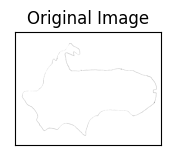

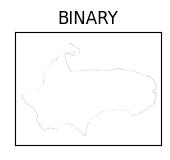

In [66]:
img = cv.imread('./binary-fixed.png', cv.IMREAD_GRAYSCALE)
assert img is not None, "file could not be read, check with os.path.exists()"


## Rotation for the original image
# img = cv.rotate(img, cv2.ROTATE_90_COUNTERCLOCKWISE)

ret,thresh1 = cv.threshold(img,127,255,cv.THRESH_BINARY)

titles = ['Original Image','BINARY']
images = [img, thresh1]
for i in range(len(images)):
    plt.subplot(2,3,i+1),plt.imshow(images[i],'gray',vmin=0,vmax=255)
    plt.title(titles[i])
    plt.xticks([]),plt.yticks([])
    plt.show()

### 1.2 Convert white and black pixels in the matrix to binary values

In [67]:
print(images[1])

[[255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 ...
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]]


Turn the pixel matrix into a binary matrix

In [68]:
lake_map = images[1] 
for i in range(len(lake_map)):
    for j in range(len(lake_map[i])):
        if lake_map[i][j] == 255:
            lake_map[i][j] = 0
        else:
            lake_map[i][j] = 1

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


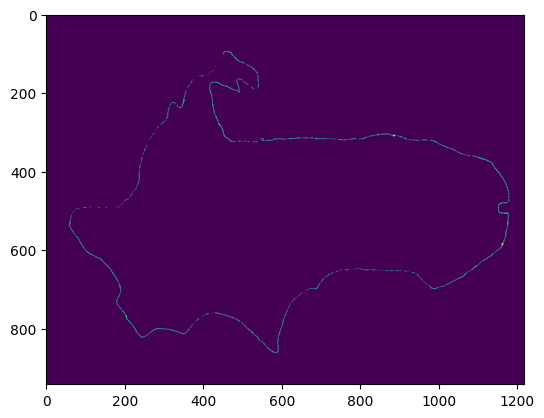

In [69]:
print(lake_map)
plt.imshow(lake_map)

True

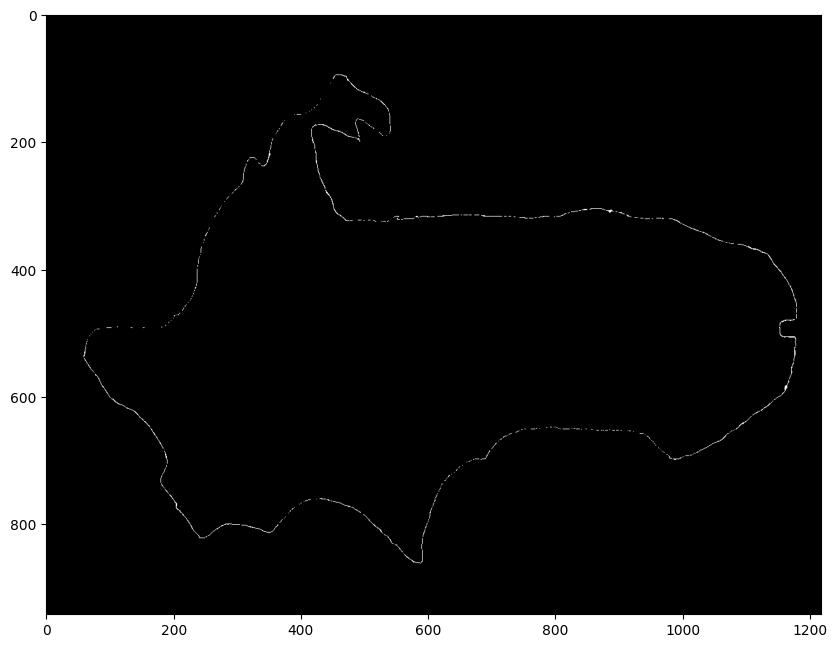

In [70]:
plt.figure(figsize=(10, 10))
plt.imshow(images[1], cmap=plt.cm.gray)
cv.imwrite('binary.jpg', images[1])

### Correcting the Axis of the image

In [71]:
# lake_map_corrected = []
# # for i in range(len(lake_map)):
# #     lake_map_corrected.append(np.flip(lake_map[i]))

lake_map_corrected = np.flipud(lake_map)
# lake_map_corrected = np.fliplr(lake_map)
print(f"lake_map dims: {lake_map.shape}, lake_map_corrected dims: {lake_map_corrected.shape}")

lake_map dims: (942, 1218), lake_map_corrected dims: (942, 1218)


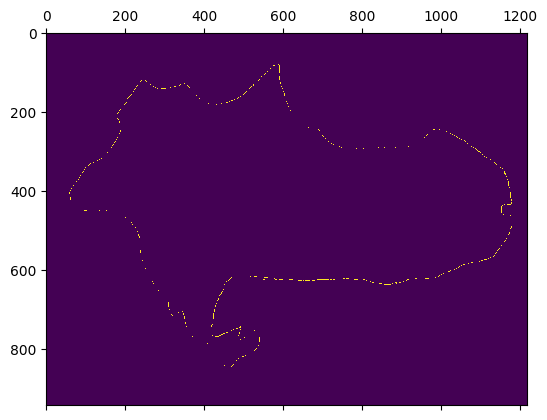

In [72]:
plt.matshow(lake_map_corrected)

### 1.3 Seperate the matrix into a set of vectors

In [73]:
#Because the y axis on lake_map is inversed, and the first index of lake represents the y axis, you can inverse the y axis by inversing the array of lake_map.


lake = np.expand_dims(lake_map_corrected, 2)

print(lake.shape)
# print(lake_map)

# #Points of known depths in x, y, z format
#TODO WHY IS IT NEGATIVE ON THE X's AND SLIGHTLY OFF ON THE Y's????

#IN FEET
depths = [[26, 12, 43/60], [18, 8, 55/60], [11, 17, 66/60], [11, 9, 81/60], [21, 16, 60/60], [33, 12, 47/60]]
    
# depths = sorted(depths, key=lambda x: x[0])

print(depths)
for y in range(len(lake_map_corrected)):
    for x in range(len(lake_map_corrected[y])):
        if not(lake_map_corrected[y][x] == 0):
            #margins (cm): left: 1.2, right: 0.7, top: 0.7, bottom, 1.9 (watch out for a few pixels on bottom that go slightly negative)
            #0.6 cm per foot on the grid
            depths.append([((x*(11/1218)-0.472441)/0.2440945), ((y*(8.5/942)-0.748031)/0.2440945), 0])

depths = sorted(depths, key=lambda x: x[0])
print(depths)
print(len(depths))

(942, 1218, 1)
[[26, 12, 0.7166666666666667], [18, 8, 0.9166666666666666], [11, 17, 1.1], [11, 9, 1.35], [21, 16, 1.0], [33, 12, 0.7833333333333333]]
[[0.2474440124455687, 11.833043717071064, 0], [0.2474440124455687, 11.870010361402484, 0], [0.2474440124455687, 11.906977005733903, 0], [0.2474440124455687, 11.943943650065323, 0], [0.28444279237043857, 11.722143784076804, 0], [0.28444279237043857, 11.759110428408224, 0], [0.28444279237043857, 11.906977005733903, 0], [0.28444279237043857, 11.943943650065323, 0], [0.28444279237043857, 11.980910294396743, 0], [0.28444279237043857, 12.017876938728165, 0], [0.28444279237043857, 12.054843583059586, 0], [0.28444279237043857, 12.091810227391006, 0], [0.28444279237043857, 12.128776871722426, 0], [0.32144157229530795, 11.648210495413963, 0], [0.32144157229530795, 11.685177139745383, 0], [0.32144157229530795, 12.054843583059586, 0], [0.32144157229530795, 12.091810227391006, 0], [0.32144157229530795, 12.128776871722426, 0], [0.32144157229530795, 12.

In [74]:
depths[0]

[0.2474440124455687, 11.833043717071064, 0]

## 2. Removing points to equalize point density in depths array 
NOTE: This doesn't work if list is sorted by x and y.
might work if sorted by theta value based off some kind of base point in the center.

Otherwise: use scipy.signal.resample or some kind of other resampling method

In [75]:
# def lineFromPoints(P, Q):
 
#     a = Q[1] - P[1]
#     b = P[0] - Q[0]
#     c = a*(P[0]) + b*(P[1])
 
#     if(b < 0):
#         return([a, -b, -c])
#     else:
#         return([a,b,-c])
# #finds the line between points P and Q
# P = [3, 2]
# Q = [2, 6]
# lineFromPoints(P, Q)

In [76]:
# import math
 
# # Function to find distance
# def shortest_distance(x1, y1, a, b, c):
      
#     d = abs((a * x1 + b * y1 + c)) / (math.sqrt(a * a + b * b))
#     return(d) #d is the perpendicular distance
     
 
# # Driver Code
# #(x1,y1) is the point
# #Equation of the line is ax + by + c = 0
# x1 = 5
# y1 = 6
# a = -2
# b = 3
# c = 4
# shortest_distance(x1, y1, a, b, c) 

A failed attempt to use Douglas Peucker to reduce size of point list (~3k points is too many for Tagir's computer)

In [77]:
"""
# source: https://karthaus.nl/rdp/
#PSEUDOCODE
#the input must be an ordered array of the points that make up the curve: [starting point, ..., ending point]
#epsilon is the amount of error you allow for: higher epsilon = less points (in the range of 0.01-0.09)
#run this on the lines that we get with Tagir's code
depths2 = depths.copy() #makes a deep copy of depths

def DouglasPeucker(PointList, epsilon):
    # Find the point with the maximum distance
    dmax = 0
    index = 0
    end = len(PointList)-1
    for i in range(2,end):
        d = shortest_distance(PointList[i][0], PointList[i][1],lineFromPoints(PointList[0], PointList[end])[0],lineFromPoints(PointList[0], PointList[end])[1],lineFromPoints(PointList[0], PointList[end])[2]) 
        if (d > dmax):
            index = i
            dmax = d

    ResultList = []

    # If max distance is greater than epsilon, recursively simplify
    if (dmax > epsilon):
        # Recursive call
        #recResults1 = [DouglasPeucker(PointList[range(1,index)], epsilon)]
        recResults = [DouglasPeucker(PointList[0:end], epsilon)]
        #recResults2 = [DouglasPeucker(PointList[range(index,end)], epsilon)]

        # Build the result list
        #ResultList = [recResults1[range(1,len(recResults1) - 1)], recResults2[range(1,len(recResults2))]]
        ResultList = recResults
    else:
        ResultList = [PointList[0], PointList[end]]
    # Return the result
    return ResultList
DouglasPeucker(depths2,0.01)
"""

"\n# source: https://karthaus.nl/rdp/\n#PSEUDOCODE\n#the input must be an ordered array of the points that make up the curve: [starting point, ..., ending point]\n#epsilon is the amount of error you allow for: higher epsilon = less points (in the range of 0.01-0.09)\n#run this on the lines that we get with Tagir's code\ndepths2 = depths.copy() #makes a deep copy of depths\n\ndef DouglasPeucker(PointList, epsilon):\n    # Find the point with the maximum distance\n    dmax = 0\n    index = 0\n    end = len(PointList)-1\n    for i in range(2,end):\n        d = shortest_distance(PointList[i][0], PointList[i][1],lineFromPoints(PointList[0], PointList[end])[0],lineFromPoints(PointList[0], PointList[end])[1],lineFromPoints(PointList[0], PointList[end])[2]) \n        if (d > dmax):\n            index = i\n            dmax = d\n\n    ResultList = []\n\n    # If max distance is greater than epsilon, recursively simplify\n    if (dmax > epsilon):\n        # Recursive call\n        #recResults1 = 

In [78]:
from sklearn.neighbors import NearestNeighbors
import statistics

nn = NearestNeighbors(n_neighbors=2,algorithm="ball_tree")

minimum = 0.01
depths3 = []
for i in depths:
    if i[2] == 0:
        depths3.append(i)
nn.fit(depths3)
# for each point, the first match is the point itself, the second match is the actual nearest neighbour
indices, distances = nn.kneighbors(depths3)
print(indices[0:10])
def function_lists2(depthithingies):
    X_LISTT = []
    Y_LISTT = []
    for n in range(len(depthithingies)):
        X_LISTT.append(depthithingies[n][0])
        Y_LISTT.append(depthithingies[n][1])
    return X_LISTT, Y_LISTT
output = function_lists2(indices)
print(len(output[1]))
print(statistics.mean(output[1]))
thing = []
for i in range(len(output[1])):
    if(output[1][i] <= statistics.mean(output[1])):
        thing.append(i)
    if(i == len(output[0])-1):
        print(len(thing))
for j in sorted(thing,reverse=True):
    del depths3[j]
depths3_x, depths3_y = function_lists2(depths3)[0], function_lists2(depths3)[1]
print(len(depths3_x))

[[0.         0.03696664]
 [0.         0.03696664]
 [0.         0.03696664]
 [0.         0.03696664]
 [0.         0.03696664]
 [0.         0.03696664]
 [0.         0.03696664]
 [0.         0.03696664]
 [0.         0.03696664]
 [0.         0.03696664]]
2962
0.04003903308435523
2664
298


In [79]:
depths[0]

[0.2474440124455687, 11.833043717071064, 0]

In [80]:
print(spatial.KDTree(depths))

In [81]:
# depths_x, depths_y = function_lists2(depths)

In [82]:
# depths4 = depths[::10]
# for i in depths:
#     if i[2] != 0:
#         depths4.append(i)
# depths4_x, depths4_y = function_lists2(depths4)

In [83]:
# plt.figure()
# plt.scatter(depths3_x, depths3_y, label='blah', color='black')
# plt.show()

A current attempt Tagir came up with to use the angle of the point relative to a center point to identify local 

This code was causing depths to be in arrays of 4 instead of 3

In [84]:
# ## Two things to account for:
# ## 1. Two points far away from each other can have the same theta, 
# ## meaning that you want to have some radius threshold where the algorithm will keep searching until it satisfies that
# ## 2. The last and first index are neighboring points
# import math
# depths5 = depths.copy()
# def function(points):
#     cp = [20,15]
#     X = []
#     Y = []
#     THETAS = []
#     for i in range(len(points)):
#         #X.append(abs(20-(points[i][0]/math.sqrt(points[i][0]**2+points[i][1]**2)))) #normalizing
#         X.append(abs(20-points[i][0]))
#         #Y.append(abs(15-points[i][1]/math.sqrt(points[i][0]**2+points[i][1]**2)))
#         Y.append(abs(15-points[i][1]))
#         THETAS.append(math.atan(Y[i]/X[i]))
#         points[i].append(THETAS[i])
#     return sorted(points, key=lambda x: x[3])
# print(function(depths5))


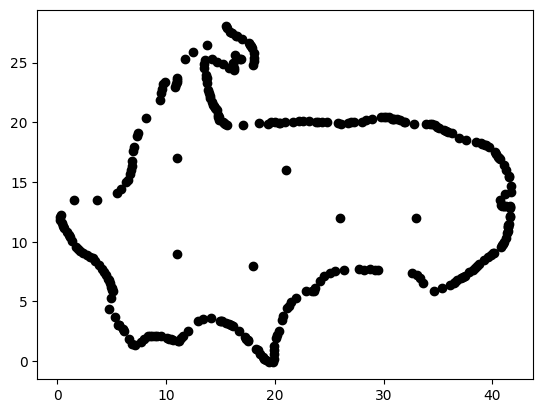

In [85]:
plt.figure()
plt.scatter(depths4_x, depths4_y, color='black')
plt.show()

In [86]:
#depths[0][2] = z of point 1

#convert(depths):

##Todo:
def function_lists(depthithingies):
    
    X_LISTT = []
    Y_LISTT = []
    Z_LISTT = []
    for n in range(len(depthithingies)):
        X_LISTT.append(depthithingies[n][0])
        Y_LISTT.append(depthithingies[n][1])
        Z_LISTT.append(depthithingies[n][2])
    return X_LISTT, Y_LISTT, Z_LISTT

MYVARIABLESTOPITDONTTOUCH = function_lists([[26, 12, 43], [18, 8, 55], [11, 17, 66], [11, 9, 81]])
print(MYVARIABLESTOPITDONTTOUCH)

([26, 18, 11, 11], [12, 8, 17, 9], [43, 55, 66, 81])


In [87]:
print(depths[0])

[0.2474440124455687, 11.833043717071064, 0]


### Failed attempt to center

len xs: 2968, len ys: 2968


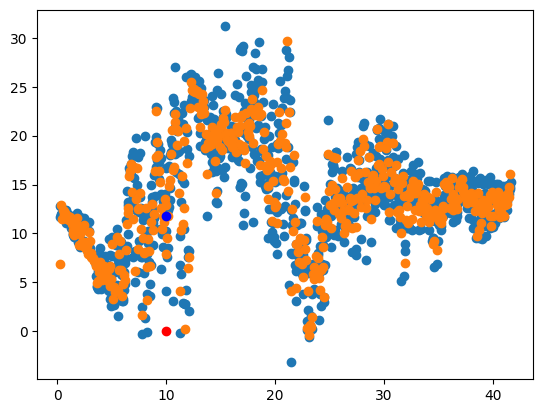

In [88]:
xs, ys, zs, = function_lists(depths)

first_point_x = xs[0]
final_point_x = xs[2967]


print(f"len xs: {len(xs)}, len ys: {len(ys)}")


f_fft = signal.resample(ys, 1000)
f_poly = signal.resample_poly(ys, 500, 2968)

xnew1 = np.linspace(first_point_x, final_point_x, 1000, endpoint=False)
xnew2 = np.linspace(first_point_x, final_point_x, 500, endpoint=False)

plt.figure()
# plt.plot(xnew, f_fft, 'b.-')
plt.scatter(xnew1, f_fft)
# plt.plot(xnew, f_poly, 'r.-')
plt.scatter(xnew2, f_poly)
# plt.plot(xs, ys, 'ko-')
plt.plot(10, ys[0], 'bo', 10, 0., 'ro')  # boundaries
# plt.legend(['resample', 'resamp_poly', 'data'], loc='best')
# plt.legend(['resample', 'resamp_poly'], loc='best')
plt.show()

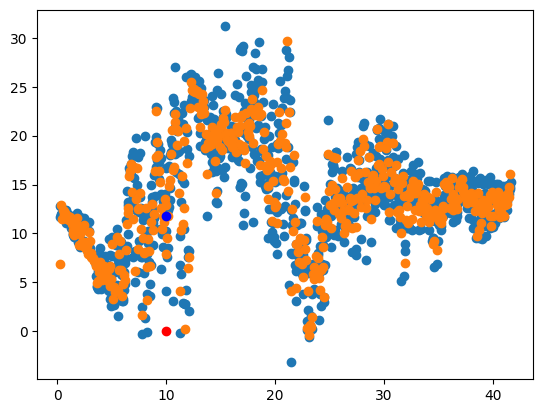

In [89]:
plt.figure()
# plt.plot(xnew, f_fft, 'b.-')
plt.scatter(xnew1, f_fft)
# plt.plot(xnew, f_poly, 'r.-')
plt.scatter(xnew2, f_poly)
# plt.plot(xs, ys, 'ko-')
plt.plot(10, ys[0], 'bo', 10, 0., 'ro')  # boundaries
# plt.legend(['resample', 'resamp_poly', 'data'], loc='best')
# plt.legend(['resample', 'resamp_poly'], loc='best')
plt.show()

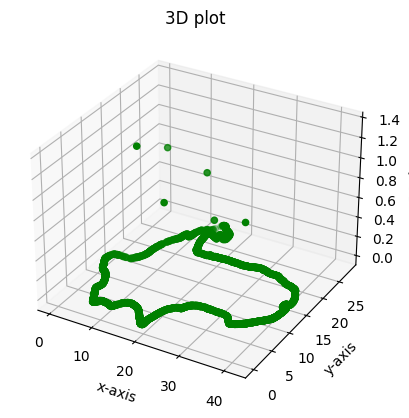

In [90]:


# creating figure
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
# ax = Axes3D(plt.figure())

plot = ax.scatter(xs, ys, zs, color='green')



# setting title and labels
ax.set_title("3D plot")
ax.set_xlabel('x-axis')
ax.set_ylabel('y-axis')
ax.set_zlabel('z-axis')
 
# displaying the plot
plt.show()
# plt.axis('off')
# view_init(elev=5, azim=5)


In [91]:
print(depths[1501])

[18.043857156307883, 25.806435274347887, 0]


## 3. Fitting a model to the points

## Polynomial regression

In [92]:
# from sklearn.preprocessing import PolynomialFeatures

# poly = PolynomialFeatures(degree = 2) 
# X_poly = poly.fit_transform(X)
# lr_poly = LinearRegression()
# lr_poly.fit(X_poly, Y)

# predicted = lr_poly.predict(poly.fit_transform(model_viz))



# r2 = lr_poly.score(poly.fit_transform(X), Y)



# plt.style.use('default')

# fig = plt.figure(figsize=(12, 4))

# ax1 = fig.add_subplot(131, projection='3d')
# ax2 = fig.add_subplot(132, projection='3d')
# ax3 = fig.add_subplot(133, projection='3d')

# axes = [ax1, ax2, ax3]

# for ax in axes:
#     ax.plot(x, y, z, color='k', zorder=15, linestyle='none', marker='o', alpha=0.5)
#     ax.scatter(xx_pred.flatten(), yy_pred.flatten(), predicted, facecolor=(0,0,0,0), s=20, edgecolor='#70b3f0')
#     ax.set_xlabel('LotArea', fontsize=12)
#     ax.set_ylabel('GrLivArea', fontsize=12)
#     ax.set_zlabel('SalePrice', fontsize=12)
#     ax.locator_params(nbins=4, axis='x')
#     ax.locator_params(nbins=5, axis='x')

# ax1.view_init(elev=28, azim=120)
# ax2.view_init(elev=4, azim=114)
# ax3.view_init(elev=60, azim=165)

# fig.suptitle('Polynomial regression, 2nd degree, Entire dataset score: $R^2 = %.3f$' % r2, fontsize=20)

# fig.tight_layout()

## Gaussian fit

In [93]:
# print(942*1218)

In [94]:
# print(len(depths))
# print(depths[0])

In [95]:
# from skimage.color import rgb2gray
# from skimage.measure import find_contours

# # Convert the image to grayscale
# gray_image = rgb2gray(image)

# # Find contours at a constant value of 0.5
# contours = find_contours(gray_image, 0.5)

# # Display the image with contours
# plt.figure(figsize=(10, 10))
# plt.imshow(image, cmap=plt.cm.gray)
# for contour in contours:
#     plt.plot(contour[:, 1], contour[:, 0], linewidth=2)
# plt.axis('off')
# plt.title('Contours on Image')
# plt.show()

In [96]:
# import matplotlib.pyplot as plt
# import skimage.io as io

# # Load the image
# image = io.imread('/mnt/data/lake.png')

# # Display the image
# plt.figure(figsize=(10, 10))
# plt.imshow(image)
# plt.axis('off')
# plt.title('Original Image')
# plt.show()

### Now we need to try to convert the map to a binary set of points where only the outline of the map is present

In [97]:
print(depths)

[[0.2474440124455687, 11.833043717071064, 0], [0.2474440124455687, 11.870010361402484, 0], [0.2474440124455687, 11.906977005733903, 0], [0.2474440124455687, 11.943943650065323, 0], [0.28444279237043857, 11.722143784076804, 0], [0.28444279237043857, 11.759110428408224, 0], [0.28444279237043857, 11.906977005733903, 0], [0.28444279237043857, 11.943943650065323, 0], [0.28444279237043857, 11.980910294396743, 0], [0.28444279237043857, 12.017876938728165, 0], [0.28444279237043857, 12.054843583059586, 0], [0.28444279237043857, 12.091810227391006, 0], [0.28444279237043857, 12.128776871722426, 0], [0.32144157229530795, 11.648210495413963, 0], [0.32144157229530795, 11.685177139745383, 0], [0.32144157229530795, 12.054843583059586, 0], [0.32144157229530795, 12.091810227391006, 0], [0.32144157229530795, 12.128776871722426, 0], [0.32144157229530795, 12.165743516053846, 0], [0.32144157229530795, 12.202710160385266, 0], [0.32144157229530795, 12.239676804716686, 0], [0.32144157229530795, 12.276643449048

In [98]:
# #Doesn't work
# map = images[2]

# count = 0

# for i in range(len(map)):
#     # print(i)
#     for j in range(len(map[i])):
#         if map[i][j] != 0:
#             count += 1

# print(count)


In [99]:
# plt.imshow(images[1])

In [102]:
def function_arrays(more_depthilinguss):
    xy_list = []
    z_list = []
    for small_list in more_depthilinguss:
        x,y,z = small_list
        xy_list.append([x,y])
        z_list.append(z)
    
    array_xys = np.array(xy_list)
    array_zs = np.array(z_list)
    return array_xys, array_zs

function_arrays(depths)

(array([[ 0.24744401, 11.83304372],
        [ 0.24744401, 11.87001036],
        [ 0.24744401, 11.90697701],
        ...,
        [41.68607753, 14.9012752 ],
        [41.68607753, 14.93824184],
        [41.68607753, 14.97520849]]),
 array([0., 0., 0., ..., 0., 0., 0.]))

In [103]:
#Using spline to find depths of oo
pointies, zss = function_arrays(depths)
spline = RBFInterpolator(pointies, zss, kernel = 'thin_plate_spline', smoothing = 0)
spline([[11,3],[8,5],[18,4],[15,26], [26,12], [18,8], [11,9], [11,8], [10,9], [15, 8]])*60

array([1.53784136e+00, 9.71718156e+00, 4.94076970e+00, 7.23612410e-04,
       4.30000000e+01, 5.50000000e+01, 8.10000000e+01, 6.73980838e+01,
       6.93782765e+01, 6.43846780e+01])

Finds the scaling quantity for our depths in our model. The below code generates topographic and 3d models of our depths using thin plate spline, which imitates the properties of a surface being pressed down at the depths that we give it. r**2 * log(r) is the formula for thin-plate spline

In [104]:
# depths4 = depths[::10]
# for i in depths:
#     if i[2] != 0:
#         depths4.append(i)
# del depths4[len(depths4)-1] #removes the last point, which is the known point (33,12,47)
# pointies, zss = separate_coordinates(depths4)
# spline = RBFInterpolator(pointies, zss, kernel='thin_plate_spline', smoothing = 0)
# spline([[33, 12]])*60 #tests what the spline's value for that point will be if the point is not in the input data set
# #our multiplier for elevation is: true z-value/spine predicted z-value
# #multiplier: 5.79

NameError: name 'separate_coordinates' is not defined

Generates a topographic map based on radial basis function interpolation with thin plate spline

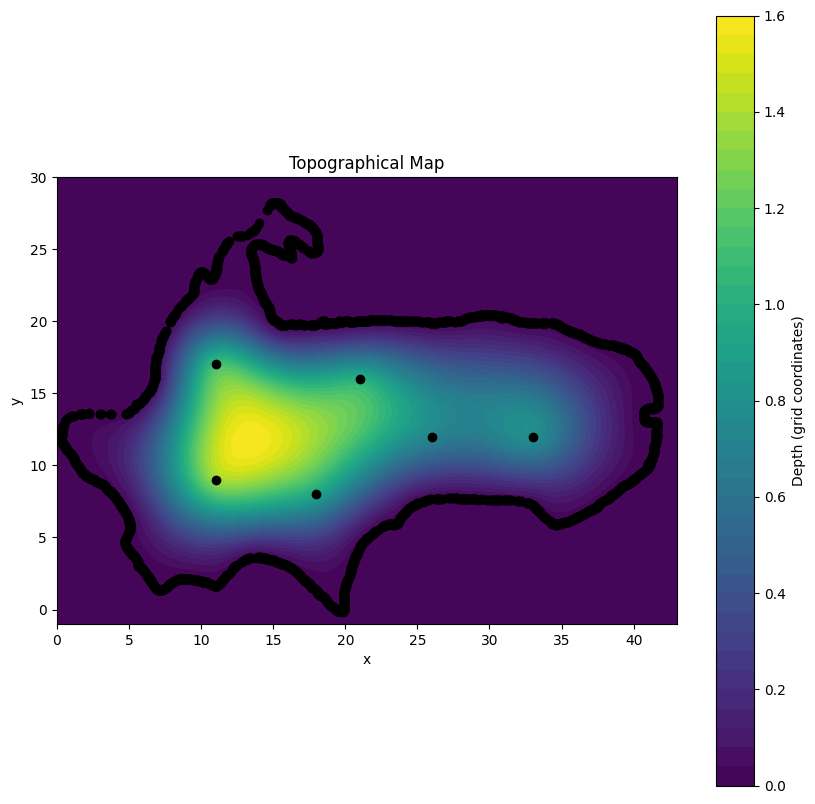

In [105]:
depths4 = depths[::10]
for i in depths:
    if i[2] != 0:
        depths4.append(i)
def separate_coordinates(x_y_z_list):
  xy_list = []
  z_list = []
  for small_list in x_y_z_list:
    x, y, z = small_list
    xy_list.append([x,y])
    z_list.append([z])
  return np.array(xy_list), np.array(z_list)

pointies, zss = separate_coordinates(depths4) #GENERATES POINTIES AND ZSS CHANGE THIS TO CHANGE BORDER POINTs

# Sample object that provides depth values at (x, y) points
class DepthProvider:
    def get_depth(self, x, y):
        # Depth calculation logic based on (x, y)
      spline = RBFInterpolator(pointies, zss, kernel='thin_plate_spline', smoothing = 0)
      return spline([[x,y]])

# Create a DepthProvider object
depth_provider = DepthProvider()

# Define the range of x and y coordinates for the topographical map
x_range = np.linspace(0, 43, 100)
y_range = np.linspace(-1, 30, 100)

# Create a meshgrid of (x, y) coordinates
x_mesh, y_mesh = np.meshgrid(x_range, y_range)

# Calculate depth values at each (x, y) point using the DepthProvider object
elevation_data = np.vectorize(depth_provider.get_depth)(x_mesh, y_mesh)

#Update elevation_data to filter out negative depths

filtered_elevation_data = np.where(elevation_data < 0, 0, elevation_data)

# Create a contour plot
plt.figure(figsize=(10, 10))
contours = plt.contourf(x_mesh, y_mesh, filtered_elevation_data, cmap='viridis', levels=40)
plt.colorbar(contours, label='Depth (grid coordinates)')
plt.scatter(depths_x, depths_y, color='black')
plt.title('Topographical Map')
plt.xlabel('x')
plt.ylabel('y')

# Show the map
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

Generate 3D Plot of Our Data

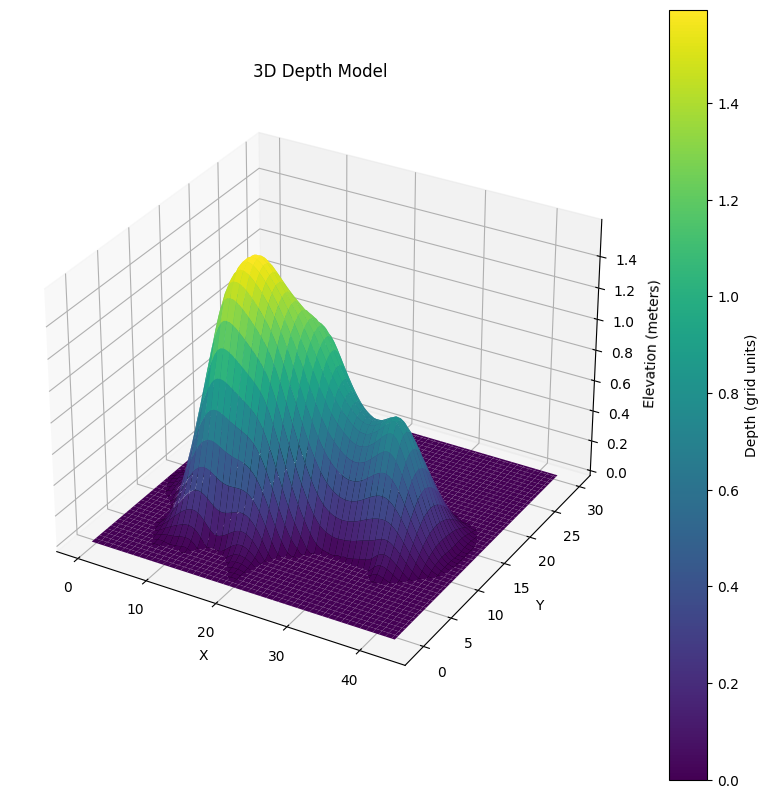

In [106]:
# Create a 3D surface plot
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# Plot the surface
surf = ax.plot_surface(x_mesh, y_mesh, filtered_elevation_data, cmap='viridis') #Multiplier for z: 5.79

# Add colorbar
fig.colorbar(surf, label='Depth (grid units)')

# Set labels and title
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Elevation (meters)')
#ax.set_aspect('equal') #if you want to see what the actual scaling would be like, uncomment this line
ax.set_title('3D Depth Model')

plt.plot(depths_x, depths_y, color='black')
plt.show()